In [1]:
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# 1.残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv=False, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                              padding=1, stride=stride)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                              padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1,
                                  stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
# 2.残差单元
def residual_unit(input_channels, num_channels, num_residuals,
                 first_block = False):
    unit = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            unit.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, stride = 2))
        else:
            unit.append(Residual(num_channels, num_channels))
    return unit

In [4]:
# 3.ResNet18模型结构
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7,stride = 2, padding = 3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b2 = nn.Sequential(*residual_unit(64, 64, 2, first_block=True))
b3 = nn.Sequential(*residual_unit(64, 128, 2))
b4 = nn.Sequential(*residual_unit(128, 256, 2))
b5 = nn.Sequential(*residual_unit(256, 512, 2))

resnet18 = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), 
                    nn.Linear(512, 10))

In [5]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in resnet18:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [6]:
d2l.try_gpu()

device(type='cuda', index=0)

RuntimeError: DataLoader worker (pid(s) 6524) exited unexpectedly

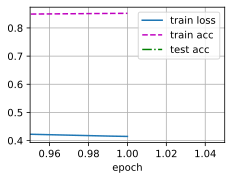

In [7]:
# 4.训练模型
lr, num_epochs, batch_size = 0.05, 1, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 96,num_wor)
d2l.train_ch6(resnet18, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())